In [1]:
#Loading the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importing all the necessary Libraries
import numpy as np 
import pandas as pd 
import pywt
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

import tensorflow
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import keras
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History 
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense,Activation, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers import Input
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.models import Model
from keras.datasets import mnist
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam

np.random.seed(1000)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#Attach the path to your dataset.
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/eardataset.csv')
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/eardataset.csv', encoding = "ISO-8859-1")

In [4]:
#Checking for null values
print(df.info())
print("----Check if Data has any null values----")
print(df.isnull().sum())
if(df.isnull().values.any()==False):
    print("\nNo null Values in the dataset")
else:
    print("\ndataset has null values")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Columns: 666 entries, unnamed to data_659
dtypes: float64(660), int64(4), object(2)
memory usage: 22.0+ MB
None
----Check if Data has any null values----
unnamed     0
subject     0
session     0
ear         0
buffer      0
           ..
data_655    0
data_656    0
data_657    0
data_658    0
data_659    0
Length: 666, dtype: int64

No null Values in the dataset


In [5]:
#Reading the csv file
df_again = pd.read_csv('/content/drive/My Drive/Colab Notebooks/eardataset.csv')
df_again.head(3)

,unnamed,subject,session,ear,buffer,block,data_0,data_1,data_2,data_3,data_4,data_5,data_6,data_7,data_8,data_9,data_10,data_11,data_12,data_13,data_14,data_15,data_16,data_17,data_18,data_19,data_20,data_21,data_22,data_23,data_24,data_25,data_26,data_27,data_28,data_29,data_30,data_31,data_32,data_33,...,data_620,data_621,data_622,data_623,data_624,data_625,data_626,data_627,data_628,data_629,data_630,data_631,data_632,data_633,data_634,data_635,data_636,data_637,data_638,data_639,data_640,data_641,data_642,data_643,data_644,data_645,data_646,data_647,data_648,data_649,data_650,data_651,data_652,data_653,data_654,data_655,data_656,data_657,data_658,data_659
0,40,0,0,left,A,40,0.000062,0.000063,0.000064,0.000067,0.000069,0.000072,0.000074,0.000077,0.000078,0.000080,0.000081,0.000083,0.000084,0.000085,0.000085,0.000085,0.000085,0.000085,0.000084,0.000083,0.000082,0.000081,0.000081,0.000081,0.000080,0.000080,0.000080,0.000081,0.000081,0.000082,0.000083,0.000084,0.000084,0.000085,...,-0.000063,-0.000063,-0.000064,-0.000063,-0.000063,-0.000062,-0.000061,-0.000061,-0.000060,-0.000059,-0.000057,-0.000056,-0.000056,-0.000054,-0.000052,-0.000051,-0.000050,-0.000049,-0.000047,-0.000046,-0.000044,-0.000043,-0.000042,-0.000042,-0.000042,-0.000042,-0.000042,-0.000043,-0.000044,-0.000045,-0.000046,-0.000048,-0.000049,-0.000051,-0.000052,-0.000052,-0.000053,-0.000053,-0.000052,-0.000051
1,41,0,0,left,A,41,0.000063,0.000064,0.000065,0.000067,0.000070,0.000072,0.000075,0.000077,0.000079,0.000080,0.000081,0.000083,0.000084,0.000085,0.000085,0.000085,0.000085,0.000084,0.000083,0.000082,0.000082,0.000081,0.000081,0.000081,0.000080,0.000079,0.000079,0.000080,0.000081,0.000081,0.000083,0.000083,0.000084,0.000084,...,-0.000055,-0.000055,-0.000055,-0.000055,-0.000054,-0.000053,-0.000052,-0.000052,-0.000052,-0.000050,-0.000049,-0.000048,-0.000047,-0.000045,-0.000044,-0.000042,-0.000041,-0.000040,-0.000039,-0.000038,-0.000036,-0.000035,-0.000034,-0.000034,-0.000034,-0.000034,-0.000035,-0.000036,-0.000036,-0.000037,-0.000039,-0.000040,-0.000042,-0.000043,-0.000044,-0.000044,-0.000044,-0.000044,-0.000044,-0.000042
2,42,0,0,left,A,42,0.000065,0.000066,0.000067,0.000069,0.000071,0.000074,0.000077,0.000079,0.000081,0.000082,0.000083,0.000085,0.000086,0.000087,0.000087,0.000087,0.000087,0.000086,0.000086,0.000084,0.000084,0.000083,0.000083,0.000082,0.000081,0.000081,0.000081,0.000082,0.000083,0.000083,0.000084,0.000085,0.000086,0.000086,...,-0.000059,-0.000059,-0.000059,-0.000058,-0.000057,-0.000057,-0.000056,-0.000056,-0.000056,-0.000054,-0.000052,-0.000051,-0.000051,-0.000049,-0.000047,-0.000046,-0.000045,-0.000044,-0.000042,-0.000041,-0.000040,-0.000039,-0.000038,-0.000037,-0.000037,-0.000037,-0.000038,-0.000039,-0.000039,-0.000040,-0.000042,-0.000043,-0.000045,-0.000046,-0.000047,-0.000047,-0.000047,-0.000047,-0.000047,-0.000045


In [6]:
#Dropping columns that are not used
df_again=df_again.drop(["unnamed", "session","ear","buffer","block"],axis=1)

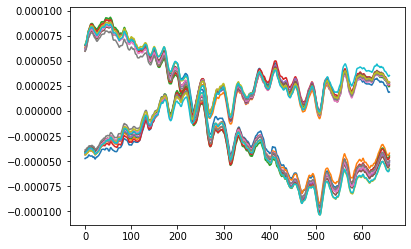

In [7]:
#View the signals in the dataset
for i in range(0,20):
    disp = df_again.iloc[i,1:661].values
    plt.plot(disp)
#10 consecutive signals are similar in a dataset while the next consecutive 10 are not.

Text(18, 97.9, '  98.05%')

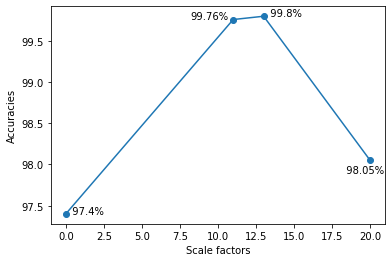

In [8]:
#Scale factor testing
import matplotlib.pyplot as plt
import seaborn as sns

x_is = [0,11,13,20]
y_is = [97.4,99.76,99.8,98.05]

plt.xlabel("Scale factors")
plt.ylabel("Accuracies")

plt.scatter(x_is,y_is)
plt.plot(x_is,y_is)
plt.annotate("  97.4%", (0, 97.4))
plt.annotate("99.76%", (8.2, 99.76))
plt.annotate("  99.8%", (13, 99.8))
plt.annotate("  98.05%", (18, 97.9))

In [16]:
#creating a dataFrame for the dataset
def subject0(subjectno, sessionno, earname, bufferid):
    dfu0=df.groupby(['subject', 'session', 'ear', 'buffer']).get_group((subjectno, sessionno, earname, bufferid)).iloc[-10:]
    return dfu0

x=subject0(34,0,'left','B')
x['subject'].iloc[0]
print(x.shape)
print(x)

(10, 666)
      unnamed  subject  session   ear  ...  data_656  data_657  data_658  data_659
2730    30662       34        0  left  ...  0.000009  0.000009  0.000009  0.000009
2731    30663       34        0  left  ...  0.000010  0.000010  0.000010  0.000010
2732    30664       34        0  left  ...  0.000010  0.000010  0.000010  0.000010
2733    30665       34        0  left  ...  0.000010  0.000010  0.000010  0.000010
2734    30666       34        0  left  ...  0.000010  0.000010  0.000010  0.000010
2735    30667       34        0  left  ...  0.000010  0.000010  0.000010  0.000010
2736    30668       34        0  left  ...  0.000010  0.000010  0.000010  0.000010
2737    30669       34        0  left  ...  0.000010  0.000010  0.000010  0.000010
2738    30670       34        0  left  ...  0.000009  0.000008  0.000008  0.000008
2739    30671       34        0  left  ...  0.000009  0.000008  0.000008  0.000008

[10 rows x 666 columns]


In [17]:
#Creating Input and Labels DataFrame

allInputTEOAEsignalsAllSubjects = pd.DataFrame([])
allOutputLabelsAllSubjects = pd.DataFrame([])
for a in range(54):
    #print(a)
    df1 = pd.DataFrame([])
    b=[0,1]              # sessions 0 and 1
    c=['left','right']   # ears 
    d=['A','B']          # buffers
    
    allFeatures =  pd.DataFrame([])
    allInputFeatures =  pd.DataFrame([])
    outputLabel =  pd.DataFrame([])
    fftValues =  pd.DataFrame([])
    psdValues =  pd.DataFrame([])
    autocorrValues = pd.DataFrame([])
        
    for q,r,s in [(q,r,s) for q in b for r in c for s in d]:
        
        # df1 contains all the 80 TEOAE signals of subject a
        df1 = df1.append(subject0(a,q,r,s))
        allInputFeatures = df1.iloc[:,6:]
    
    allInputTEOAEsignalsAllSubjects = pd.concat([allInputTEOAEsignalsAllSubjects.reset_index(drop=True),
                                                 allInputFeatures.reset_index(drop=True)], axis=0)
    # the following gets you the class label <= subject no.[0,1,2,...,53]
    outputLabel = df1.iloc[:,1] 
    #print("OutputLabel:",outputLabel)
    #allOutputLabelsAllSubjects = allOutputLabelsAllSubjects.append(outputLabel)
    #append didn't work for output so using pd.cat instead
    allOutputLabelsAllSubjects = pd.concat([allOutputLabelsAllSubjects.reset_index(drop=True),
                                            outputLabel.reset_index(drop=True)], axis=0)
    #print(allInputTEOAEsignalsAllSubjects.shape)
    #print(allOutputLabelsAllSubjects.shape)


In [18]:
# save extracted dataframe locally
X=pd.DataFrame([])
y=pd.DataFrame([])
xsave = pd.DataFrame([])
ysave = pd.DataFrame([])
X = allInputTEOAEsignalsAllSubjects
y = allOutputLabelsAllSubjects
xsave = X
ysave = y
xsave.to_pickle('dataX.pkl')
ysave.to_pickle('labelY.pkl')

In [19]:
#Load from pkl files
X = pd.read_pickle('dataX.pkl')
y = pd.read_pickle('labelY.pkl')

In [20]:
#Splitting 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2)

In [21]:
#Checking the dimensions of train and test array
print(np.asarray(X_train).shape)
print(np.asarray(X_test).shape)
print(np.asarray(y_train).shape)
print(np.asarray(y_test).shape)
labels_train = list(map(lambda x: int(x), np.asarray(y_train)))
print(np.asarray(labels_train).shape)

(2592, 660)
(1728, 660)
(2592, 1)
(1728, 1)
(2592,)


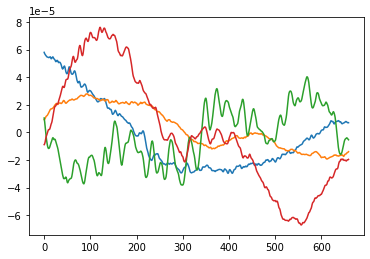

In [22]:
# Check if continuous waves are similar to each other in X_train
for i in range(1,5):
    X_disp = X_train.iloc[i,:].values
    plt.plot(X_disp)
#Conclusion : NOPE!

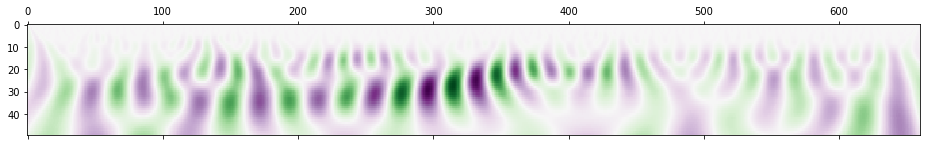

In [23]:
#scales = range(1,661)
scales = range(1,51)
waveletname = 'morl'
train_size = 3456
test_size= 864

#################################################
### plotting CWT of a single TEOAE signal  ######
#################################################
coeff, freq = pywt.cwt(X_train.iloc[3,:], scales, waveletname, 1)
plt.matshow(coeff,  cmap='PRGn', aspect='auto')
plt.show()

In [24]:
#CWT
scales = range(1,51)
waveletname = 'morl'
train_size = X_train.shape[0]
test_size= X_test.shape[0]

#########################################################
### creating a tensor to store CWT matrices of train egs#
#########################################################
train_data_cwt = np.ndarray(shape=(train_size, 50, 660)) 

for ii in range(0,train_size):
    # if ii % 50 == 0: #len(X_train) == 0:
    #     print(ii)
    signal = X_train.iloc[ii, :]
    coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
    coeff_ = coeff[:,:660]
    train_data_cwt[ii, :, :] = coeff_
    #train_data_cwt[:, :, ii] = coeff_

###########################################################
### creating a tensor to store CWT matrices of test egs ###
###########################################################
test_data_cwt = np.ndarray(shape=(test_size, 50, 660))

for ii in range(0,test_size):
    # if ii % 50 == 0:
    #     print(ii)
    signal = X_test.iloc[ii, :]
    coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
    coeff_ = coeff[:,:660]
    test_data_cwt[ii, :, :] = coeff_
    #test_data_cwt[:, :, ii] = coeff_

###########################################################
### convert the labels from float to int of train and test egs
###########################################################
labels_train = list(map(lambda x: int(x), np.asarray(y_train)))
labels_test = list(map(lambda x: int(x), np.asarray(y_test)))

###########################################################
### putting all the train and test CWT data             ###
###########################################################
x_train = train_data_cwt
y_train = list(labels_train[:train_size])
x_test = test_data_cwt
y_test = list(labels_test[:test_size])

In [25]:
#Convert the labels to array
y_test_np = np.asarray(y_test)
y_train_np = np.asarray(y_train)

In [26]:
#Printing shapes
print(np.asarray(x_train).shape)
print(np.asarray(x_test).shape)
print(np.asarray(y_train).shape)
print(np.asarray(y_test).shape)
print(len(x_train))
print(len(x_test))

(2592, 50, 660)
(1728, 50, 660)
(2592,)
(1728,)
2592
1728


In [27]:
# save numpy array
np.save('x_train_CNN', x_train)
np.save('x_test_CNN', x_test)
np.save('y_test_CNN', y_test_np)
np.save('y_train_CNN', y_train_np)

In [28]:
#load data
x_train = np.load('x_train_CNN.npy')
x_test = np.load('x_test_CNN.npy')
y_train_np = np.load('y_train_CNN.npy')
y_test_np = np.load('y_test_CNN.npy')

In [29]:
#ResNet50:
history = History()
 
img_x = x_train.shape[1] # = no.of samples of each TEOAE signal = 660
img_y = x_train.shape[2] 
img_z = 3

in_shape = (img_x, img_y, img_z)
print(in_shape)
base_model = ResNet50(weights='imagenet',include_top=False,input_shape=in_shape,classes=54)

(50, 660, 3)
94773248/94765736 [==============================] - 1s 0us/step


In [30]:
#ResNet50:
model= Sequential()
model.add(base_model)
model.add(Flatten())
#model.add(54,activation=('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 21, 2048)       23587712  
_________________________________________________________________
flatten (Flatten)            (None, 86016)             0         
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [31]:
#ResNet50:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print(x_train.shape)
print(x_test.shape)
num_classes = 54




x_train_cnn = x_train.reshape(2592,50,660,1)#len(x_train),img_x, img_y, img_z)
x_test_cnn = x_test.reshape(1728,50,660,1)#len(x_test),img_x, img_y, img_z)
rgb_train = np.repeat(x_train_cnn, 3, -1)
rgb_test = np.repeat(x_test_cnn,3,-1)
# y_train_cnn = keras.utils.to_categorical(y_train_np, num_classes)
# y_test_cnn = keras.utils.to_categorical(y_test_np, num_classes)

(2592, 50, 660)
(1728, 50, 660)


In [32]:
#Compile the Model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [33]:
#obtain the flattened output for training
features_xtrain=model.predict(rgb_train) #training
features_xtrain.shape
#VANDHURCHUUUUU YAAAAYYYY

(2592, 86016)

In [34]:
#Flattened output for Testing
features_xtest=model.predict(rgb_test) #testing
features_xtest.shape

(1728, 86016)

In [35]:
# PCA on the flattened array

scaler = StandardScaler()
scaler.fit(features_xtrain)

features_xtrain = scaler.transform(features_xtrain)
features_xtest = scaler.transform(features_xtest)

pca = PCA(.95)  #using 95% of the variance in the model.

pca.fit(features_xtrain)

features_xtrain = pca.transform(features_xtrain)
features_xtest = pca.transform(features_xtest)

In [36]:
 #SVM classifier

svm=SVC()
svm.fit(features_xtrain,y_train_np)

#training accuracy
acc_svm_train=round(svm.score(features_xtrain,y_train_np)*100,2)
print("Training Accuracy:",acc_svm_train)

#testing accuracy
acc_svm_test=round(svm.score(features_xtest,y_test_np)*100,2)
print("Testing accuracy:",acc_svm_test)

Training Accuracy: 99.88
Testing accuracy: 99.94


In [37]:
# MLP classification
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,150,100), max_iter=50, alpha=0.0001,
                     solver='adam', verbose=10,  random_state=0,tol=0.000001)
mlp_clf.fit(features_xtrain, y_train_np)

pred_test = mlp_clf.predict(features_xtest) #testing accuracy
accuracy_score(y_test_np, pred_test)*100

Iteration 1, loss = 3.75192610
Iteration 2, loss = 2.46339145
Iteration 3, loss = 1.51219380
Iteration 4, loss = 0.74639365
Iteration 5, loss = 0.30530745
Iteration 6, loss = 0.12146731
Iteration 7, loss = 0.05475613
Iteration 8, loss = 0.03012903
Iteration 9, loss = 0.02034891
Iteration 10, loss = 0.01511866
Iteration 11, loss = 0.01168760
Iteration 12, loss = 0.00954251
Iteration 13, loss = 0.00801381
Iteration 14, loss = 0.00685833
Iteration 15, loss = 0.00596709
Iteration 16, loss = 0.00525507
Iteration 17, loss = 0.00465024
Iteration 18, loss = 0.00416022
Iteration 19, loss = 0.00376514
Iteration 20, loss = 0.00341604
Iteration 21, loss = 0.00311642
Iteration 22, loss = 0.00285887
Iteration 23, loss = 0.00263838
Iteration 24, loss = 0.00243872
Iteration 25, loss = 0.00226709
Iteration 26, loss = 0.00211281
Iteration 27, loss = 0.00197932
Iteration 28, loss = 0.00185262
Iteration 29, loss = 0.00174533
Iteration 30, loss = 0.00164135
Iteration 31, loss = 0.00155235
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


100.0

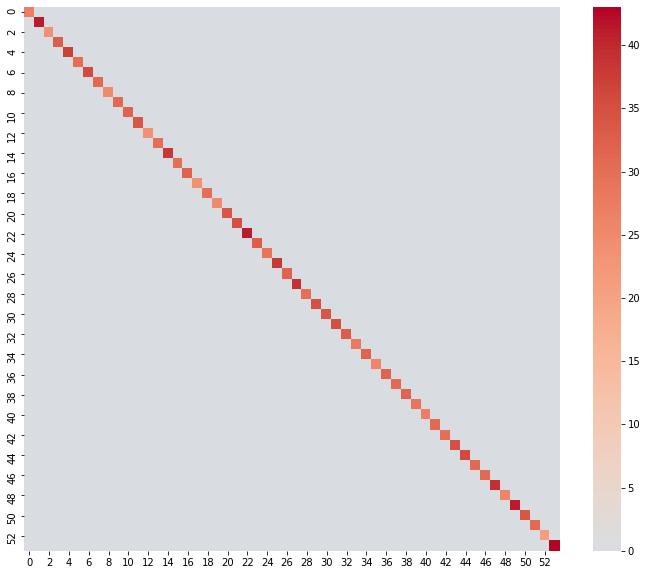

In [38]:
# Plotting the Confusion matrix
cm = confusion_matrix(y_test_np, pred_test)
plt.figure(figsize=(12,10))
sns.heatmap(cm, center=True, cmap='coolwarm')
plt.show()

In [39]:
#Random Forest Classifier

# Create the model with 100 trees
model_rf = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')

model_rf.fit(features_xtrain, y_train_np)
pred_test = model_rf.predict(features_xtest) #testing accuracy

accuracy_score(y_test_np, pred_test)*100

100.0

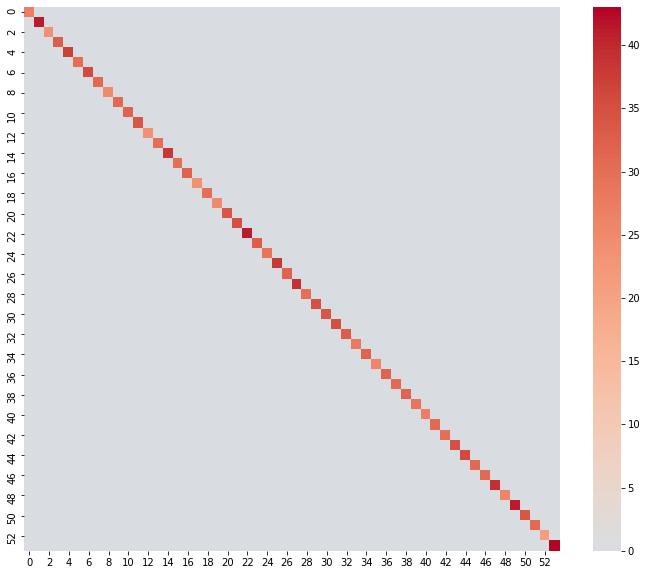

In [40]:
# Plotting the Confusion matrix
cm = confusion_matrix(y_test_np, pred_test)

plt.figure(figsize=(12,10))
sns.heatmap(cm, center=True, cmap='coolwarm')
plt.show()

In [41]:
# K nearest neighbours algorithm 

knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(features_xtrain, y_train_np) 
pred_test = knn.predict(features_xtest) #testing accuracy
accuracy_score(y_test_np, pred_test)*100

100.0

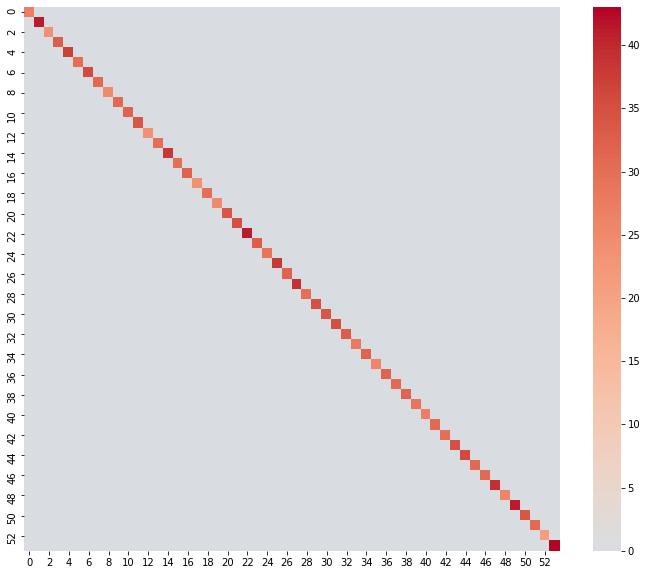

In [42]:
cm = confusion_matrix(y_test_np, pred_test)

plt.figure(figsize=(12,10))
sns.heatmap(cm, center=True, cmap='coolwarm')
plt.show()

In [43]:
# XGBoost classifier

from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(features_xtrain, y_train_np)
pred_test = model.predict(features_xtest) #testing accuracy
accuracy_score(y_test_np, pred_test)*100

98.09027777777779

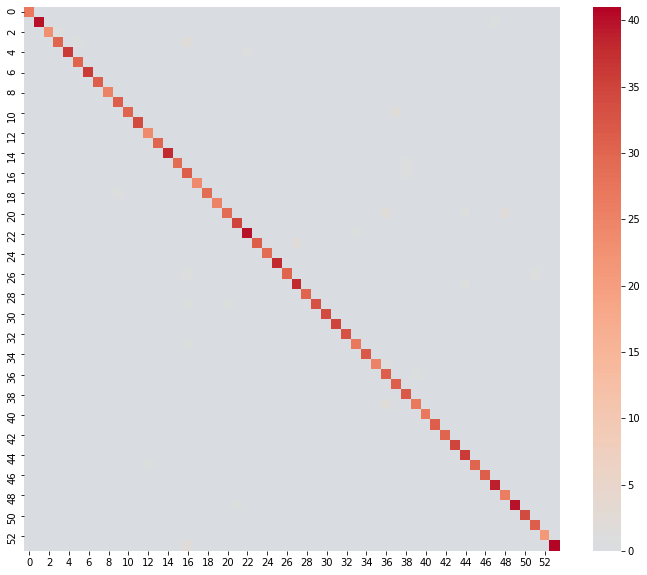

In [44]:
cm = confusion_matrix(y_test_np, pred_test)

plt.figure(figsize=(12,10))
sns.heatmap(cm, center=True, cmap='coolwarm')
plt.show()